In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt

In [2]:
# Daten einlesen
data = pd.read_csv('final_data_02.csv')

In [3]:
data.head(1)

,R1_1,R1_3,R1_5,R1_7,R1_9,R1_11,R4_1,R4_3,R4_5,R4_7,R4_9,R4_11,Label
0,0.009509,0.002739,0.009983,0.012739,0.043292,0.027413,0.005446,0.013729,0.022559,0.007042,0.014863,0.015488,drill


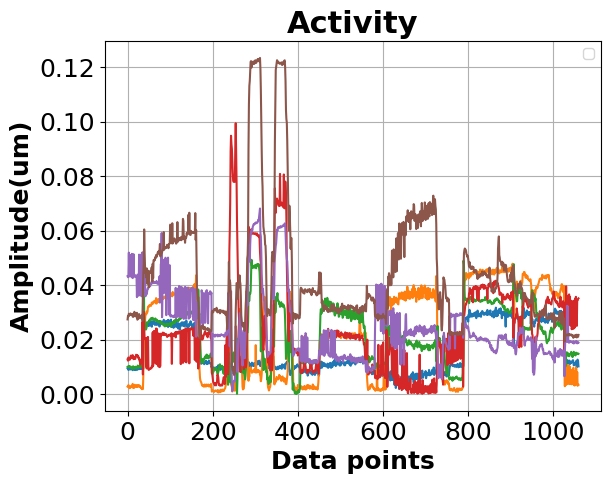

In [4]:

plt.title('Activity', fontsize=22, fontweight='bold')
plt.xlabel('Data points', fontsize=18, fontweight='bold')
plt.ylabel('Amplitude(um)', fontsize=18, fontweight='bold')
plt.grid(True)
plt.legend(['R1_1'])

# Set the text size of the tick labels on both axes
plt.tick_params(axis='both', labelsize=18)
plt.plot(data.index, data[['R1_1','R1_3', 'R1_5', 'R1_7', 'R1_9', 'R1_11']])

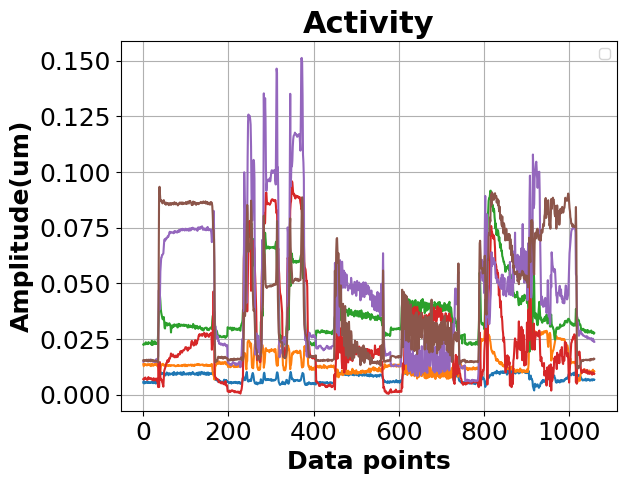

In [5]:
plt.title('Activity', fontsize=22, fontweight='bold')
plt.xlabel('Data points', fontsize=18, fontweight='bold')
plt.ylabel('Amplitude(um)', fontsize=18, fontweight='bold')
plt.grid(True)
plt.legend(['R1_1'])

# Set the text size of the tick labels on both axes
plt.tick_params(axis='both', labelsize=18)
plt.plot(data.index, data[['R4_1','R4_3', 'R4_5', 'R4_7', 'R4_9', 'R4_11', ]])

In [6]:
X = data.drop(['Label'], axis=1)
y = data['Label']

In [7]:
X

,R1_1,R1_3,R1_5,R1_7,R1_9,R1_11,R4_1,R4_3,R4_5,R4_7,R4_9,R4_11
0,0.009509,0.002739,0.009983,0.012739,0.043292,0.027413,0.005446,0.013729,0.022559,0.007042,0.014863,0.015488
1,0.009375,0.002902,0.010054,0.012271,0.042885,0.028700,0.006215,0.012851,0.022911,0.007343,0.015195,0.015166
2,0.008865,0.003296,0.010266,0.013440,0.043616,0.028478,0.005148,0.013241,0.022589,0.006918,0.015198,0.015465
3,0.009710,0.002949,0.010087,0.012824,0.051911,0.029503,0.005121,0.013964,0.022762,0.007152,0.015396,0.015486
4,0.009137,0.002178,0.010328,0.013190,0.043166,0.028862,0.005653,0.013725,0.023074,0.007641,0.015412,0.015303
...,...,...,...,...,...,...,...,...,...,...,...,...
1055,0.009909,0.003685,0.014902,0.025012,0.019150,0.020773,0.006870,0.010924,0.028244,0.009327,0.024279,0.015850
1056,0.012283,0.008089,0.014744,0.034419,0.018611,0.021398,0.006569,0.011272,0.027995,0.010128,0.025185,0.015723
1057,0.012652,0.003050,0.014787,0.034449,0.018964,0.021626,0.006656,0.009906,0.028233,0.009449,0.024658,0.016070
1058,0.012215,0.003331,0.014912,0.034970,0.019104,0.021012,0.006972,0.010424,0.027395,0.009592,0.023784,0.016323


In [8]:
def reciprocal(d):

    # Identify numeric columns
    numeric_columns = d.select_dtypes(include=np.number).columns
    
    # Calculate reciprocal values for non-zero elements and replace zeros with a small value (1e-6)
    d[numeric_columns] = np.where(d[numeric_columns] != 0, 1 / d[numeric_columns], 1e-6)
    
    return d
#data = reciprocal(data)
#data

In [9]:
# Konvertiere Labels in numerische Werte
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_encoded

array([0, 0, 0, ..., 4, 4, 4])

In [10]:
# Teile die Daten in Trainings- und Testsets auf
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.3, random_state=42 )

In [11]:
# Sliding Window-Technik
window_size = 20

In [12]:
# Erstelle Sliding Windows für Trainingsdaten
X_train_windows = []
y_train_windows = []
for i in range(len(X_train) - window_size):
    X_train_windows.append(X_train.iloc[i:i+window_size])
    y_train_windows.append(y_train[i+window_size])

X_train_windows = np.array(X_train_windows)
y_train_windows = np.array(y_train_windows)



[[[0.00962217 0.00225505 0.0098526  ... 0.00775616 0.01528776 0.01545977]
  [0.01147913 0.00851399 0.04483481 ... 0.08748218 0.09619269 0.04966156]
  [0.01204668 0.02104953 0.02852994 ... 0.02084232 0.05060114 0.02431883]
  ...
  [0.00818939 0.00308018 0.01275662 ... 0.00061428 0.01799076 0.0154012 ]
  [0.02601152 0.03766677 0.02685126 ... 0.02211049 0.07467814 0.08608519]
  [0.0075968  0.03758833 0.0183734  ... 0.0343442  0.01545239 0.0271799 ]]

 [[0.01147913 0.00851399 0.04483481 ... 0.08748218 0.09619269 0.04966156]
  [0.01204668 0.02104953 0.02852994 ... 0.02084232 0.05060114 0.02431883]
  [0.0260336  0.0361911  0.02603353 ... 0.01984214 0.07433784 0.08633491]
  ...
  [0.02601152 0.03766677 0.02685126 ... 0.02211049 0.07467814 0.08608519]
  [0.0075968  0.03758833 0.0183734  ... 0.0343442  0.01545239 0.0271799 ]
  [0.01007417 0.00170243 0.01371197 ... 0.07741676 0.12523638 0.06535948]]

 [[0.01204668 0.02104953 0.02852994 ... 0.02084232 0.05060114 0.02431883]
  [0.0260336  0.036191

In [13]:
# Erstelle Sliding Windows für Testdaten
X_test_windows = []
y_test_windows = []
for i in range(len(X_test) - window_size):
    X_test_windows.append(X_test.iloc[i:i+window_size])
    y_test_windows.append(y_test[i+window_size])

X_test_windows = np.array(X_test_windows)
y_test_windows = np.array(y_test_windows)

In [14]:
# Überprüfe die Form der Eingabedaten
print("Shape von X_train_windows vor Anpassung:", X_train_windows.shape)

Shape von X_train_windows vor Anpassung: (722, 20, 12)


In [15]:
# Passe die Form der Eingabedaten an
X_train_windows = np.reshape(X_train_windows, (X_train_windows.shape[0], X_train_windows.shape[1], X_train_windows.shape[2]))

In [16]:
y_train_windows = np.reshape(y_train_windows, (y_train_windows.shape[0]))

In [18]:
# Überprüfe erneut die Form der Eingabedaten
print("Shape von X_train_windows nach Anpassung:", X_train_windows.shape)

Shape von X_train_windows nach Anpassung: (722, 20, 12)


In [19]:
num_classes = len(label_encoder.classes_)  # Anzahl der Klassen

In [20]:

# LSTM-Modell
model = Sequential()
model.add(LSTM(256, return_sequences=True, input_shape=(X_train_windows.shape[1], X_train_windows.shape[2])))
model.add(Dropout(0.5))
model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(64))
model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

In [21]:
# Kompilieren des Modells
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [22]:

print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 20, 256)           275456    
                                                                 
 dropout (Dropout)           (None, 20, 256)           0         
                                                                 
 lstm_1 (LSTM)               (None, 20, 128)           197120    
                                                                 
 dropout_1 (Dropout)         (None, 20, 128)           0         
                                                                 
 lstm_2 (LSTM)               (None, 64)                49408     
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense (Dense)               (None, 100)               6

In [23]:
# Trainiere das Modell
history = model.fit(X_train_windows, y_train_windows, epochs=100, batch_size=16, validation_data=(X_test_windows, y_test_windows))

Epoch 1/100
46/46 [==============================] - 8s 67ms/step - loss: 1.5983 - accuracy: 0.2881 - val_loss: 1.6199 - val_accuracy: 0.2483
Epoch 2/100
46/46 [==============================] - 2s 43ms/step - loss: 1.5821 - accuracy: 0.3033 - val_loss: 1.6020 - val_accuracy: 0.2483
Epoch 3/100
46/46 [==============================] - 2s 41ms/step - loss: 1.5880 - accuracy: 0.3033 - val_loss: 1.6083 - val_accuracy: 0.2483
Epoch 4/100
46/46 [==============================] - 2s 42ms/step - loss: 1.5827 - accuracy: 0.3033 - val_loss: 1.6033 - val_accuracy: 0.2483
Epoch 5/100
46/46 [==============================] - 2s 41ms/step - loss: 1.5839 - accuracy: 0.3033 - val_loss: 1.6092 - val_accuracy: 0.2483
Epoch 6/100
46/46 [==============================] - 2s 41ms/step - loss: 1.5802 - accuracy: 0.3033 - val_loss: 1.6074 - val_accuracy: 0.2483
Epoch 7/100
46/46 [==============================] - 2s 43ms/step - loss: 1.5852 - accuracy: 0.3033 - val_loss: 1.6068 - val_accuracy: 0.2483
Epoch 

In [24]:
# Überprüfe die Form der Testdaten
print("Shape von X_test_windows vor Anpassung:", X_test_windows.shape)

Shape von X_test_windows vor Anpassung: (298, 20, 12)


In [25]:
# Passe die Form der Testdaten an
X_test_windows = np.reshape(X_test_windows, (X_test_windows.shape[0], X_test_windows.shape[1], X_test_windows.shape[2]))

In [26]:
# Überprüfe erneut die Form der Testdaten
print("Shape von X_test_windows nach Anpassung:", X_test_windows.shape)

Shape von X_test_windows nach Anpassung: (298, 20, 12)


In [27]:
# Evaluieren des Modells
y_pred = model.predict(X_test_windows)
y_pred_labels = np.argmax(y_pred, axis=1)
y_pred_labels = label_encoder.inverse_transform(y_pred_labels)

10/10 [==============================] - 1s 24ms/step


In [28]:
# Konvertiere vorhergesagte Labels in Label-Strings
y_test_labels = label_encoder.inverse_transform(y_test_windows)

In [29]:
# Berechne die Genauigkeit
accuracy = accuracy_score(y_test_labels, y_pred_labels)

In [30]:
# Gib jedes Element der vorhergesagten und tatsächlichen Labels aus
for pred_label, true_label in zip(y_pred_labels, y_test_labels):
    print("Predicted Label:", pred_label)
    print("True Label:", true_label)
    print("------------------------------------------------------")

print("Accuracy:", accuracy)

Predicted Label: screw
True Label: lifting
------------------------------------------------------
Predicted Label: screw
True Label: sanding
------------------------------------------------------
Predicted Label: screw
True Label: painting
------------------------------------------------------
Predicted Label: screw
True Label: sanding
------------------------------------------------------
Predicted Label: screw
True Label: screw
------------------------------------------------------
Predicted Label: screw
True Label: lifting
------------------------------------------------------
Predicted Label: screw
True Label: drill
------------------------------------------------------
Predicted Label: screw
True Label: screw
------------------------------------------------------
Predicted Label: screw
True Label: drill
------------------------------------------------------
Predicted Label: screw
True Label: screw
------------------------------------------------------
Predicted Label: screw
True L

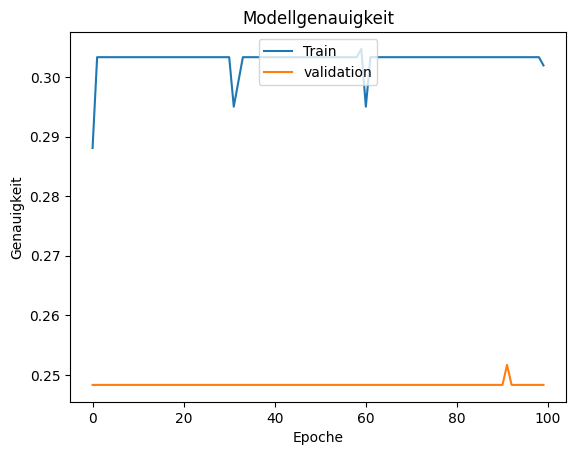

In [31]:
# Plot der Trainings- und Validierungsgenauigkeit
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Modellgenauigkeit')
plt.ylabel('Genauigkeit')
plt.xlabel('Epoche')
plt.legend(['Train', 'validation'], loc='upper center')
plt.show()